# Univariate results, basic feature engineering

In this notebook the following approaches are implemented:
- no feature engineering
- minmax scaling
- differenecing
- differencing + log transforms

In [1]:
from one_dimensional_time_series_forecasting import time_series_prediction, hit_rate, invert_first_difference,invert_first_difference_2,invert_scaling, invert_first_difference_with_log_2
import pandas as pd

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# interactive figures
%matplotlib widget 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from tabulate import tabulate


2022-05-11 17:43:06.083897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-11 17:43:06.083918: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import sys
import warnings
import os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

# 1. Baseline: no feature engineering / minmax only

### Need to test this cell below.

In [ ]:
financial_assets = ['S&P500','Apple','EurUsd','CrudeOil'] # AirPassengers',
feat_engineering = 'minmax'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)


    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(df[f'{column_to_predict}'][0:-split].to_numpy().reshape(-1,1)).flatten()
    scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=True,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=True,n_batch=128)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()


    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model}

    # store evaulation results for different models
    model_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10)
        # wrangle results
        
        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
        ax[0].set_ylabel('Close')

        ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df_walk_forward['value'].to_numpy()
        model_pred_results[model_name] = df_walk_forward['prediction'].to_numpy()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results.png')



## 1.1 S&P 500

In [ ]:
# import some data
df = pd.read_csv('./test_data/S&P500_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
df.drop(labels='Adj Close',axis=1,inplace=True)
df.plot(x='Date',y='Close',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
plt.tight_layout()
display(df)

In [ ]:
# some forecasting parameters
window_length = 10
split = 500

# scaled input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(df['Close'][0:-split].to_numpy().reshape(-1,1)).flatten()
scaled_test_data = scaler.transform(df['Close'][-split:].to_numpy().reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction('sp500_minmax',df['Date'],scaled_input_data,window_length,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=True)
blah.neural_net_mlp(model_tunning=True)
blah.lstm(model_tunning=True, verbose=0)
blah.naive_model()

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()

### walk forward validation results

In [ ]:
financial_asset = 'sp500'
mapping = {'LinearReg':blah.linear_regression_model,
            'svr':blah.svr_model,
            'MLP':blah.mlp_model,
            'LSTM':blah.lstm_model}
feat_engineering = 'minmax'

# store evaulation results for different models
model_results = []

# apply walkforward for all models
for model_name in mapping.keys():

    # retrieve model
    model = mapping[model_name]

    # apply walk forward and save results
    train_len = 225
    test_len = 25
    df_walk_forward, df, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,train_len=train_len,test_len=test_len,train_frequency=10)

    # wrangle results
    
    # plots
    df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
    
    fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
    ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
    ax[0].set_ylabel('Close')

    ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
    ax[1].set_title('Walk forward error through time')
    ax[1].set_xlabel('Dates')
    ax[1].legend()

    max = df_walk_forward.shape[0]
    ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
    ax[1].tick_params(rotation=30)
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel('Date')
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{financial_asset}_{model_name}_{feat_engineering}_wf.png',facecolor='w')
    plt.close()

    # tables 
    model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

# place into df
df_conclusion_wf = pd.DataFrame.from_records(model_results)
df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_results_summary_wf.csv')
latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
with open(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_latex_table_wf.txt',"w") as my_latex_table:
    my_latex_table.write(latex_table)


## 1.2 Gold price

In [ ]:
# import some data
df = pd.read_csv('./test_data/Gold_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
df.drop(labels='Adj Close',axis=1,inplace=True)
df.plot(x='Date',y='Close',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
plt.tight_layout()
display(df)

In [ ]:
# some forecasting parameters
window_length = 10
split = 500

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(df['Close'][0:-split].to_numpy().reshape(-1,1)).flatten()
scaled_test_data = scaler.transform(df['Close'][-split:].to_numpy().reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction('gold_minmax',df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=True)
blah.neural_net_mlp(model_tunning=True)
blah.lstm(model_tunning=True)
blah.naive_model()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()

In [ ]:
financial_asset = 'gold'
mapping = {'LinearReg':blah.linear_regression_model,
            'svr':blah.svr_model,
            'MLP':blah.mlp_model,
            'LSTM':blah.lstm_model}
feat_engineering = 'minmax'

# store evaulation results for different models
model_results = []

# apply walkforward for all models
for model_name in mapping.keys():

    # retrieve model
    model = mapping[model_name]

    # apply walk forward and save results
    train_len = 225
    test_len = 25
    df_walk_forward, df, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,train_len=train_len,test_len=test_len,train_frequency=10)

    # wrangle results
    
    # plots
    df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
    
    fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
    ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
    ax[0].set_ylabel('Close')

    ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
    ax[1].set_title('Walk forward error through time')
    ax[1].set_xlabel('Dates')
    ax[1].legend()

    max = df_walk_forward.shape[0]
    ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
    ax[1].tick_params(rotation=30)
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel('Date')
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{financial_asset}_{model_name}_{feat_engineering}_wf.png',facecolor='w')
    plt.close()

    # tables 
    model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

# place into df
df_conclusion_wf = pd.DataFrame.from_records(model_results)
df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_results_summary_wf.csv')
latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
with open(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_latex_table_wf.txt',"w") as my_latex_table:
    my_latex_table.write(latex_table)


## 1.3 USD / EUR exchange rate

In [ ]:
# import some data
df = pd.read_csv('./test_data/EurUsd_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
df.drop(labels='Adj Close',axis=1,inplace=True)
df.plot(x='Date',y='Close',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
plt.tight_layout()
display(df)

In [ ]:
# some forecasting parameters
window_length = 10
split = 500

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(df['Close'][0:-split].to_numpy().reshape(-1,1)).flatten()
scaled_test_data = scaler.transform(df['Close'][-split:].to_numpy().reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction('usdeur_minmax',df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=True)
blah.neural_net_mlp(model_tunning=True)
blah.lstm(model_tunning=True)
blah.naive_model()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()

In [ ]:
financial_asset = 'usdeur'
mapping = {'LinearReg':blah.linear_regression_model,
            'svr':blah.svr_model,
            'MLP':blah.mlp_model,
            'LSTM':blah.lstm_model}
feat_engineering = 'minmax'

# store evaulation results for different models
model_results = []

# apply walkforward for all models
for model_name in mapping.keys():

    # retrieve model
    model = mapping[model_name]

    # apply walk forward and save results
    train_len = 225
    test_len = 25
    df_walk_forward, df, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,train_len=train_len,test_len=test_len,train_frequency=10)

    # wrangle results
    
    # plots
    df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
    
    fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
    ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
    ax[0].set_ylabel('Close')

    ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
    ax[1].set_title('Walk forward error through time')
    ax[1].set_xlabel('Dates')
    ax[1].legend()

    max = df_walk_forward.shape[0]
    ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
    ax[1].tick_params(rotation=30)
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel('Date')
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{financial_asset}_{model_name}_{feat_engineering}_wf.png',facecolor='w')
    plt.close()

    # tables 
    model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

# place into df
df_conclusion_wf = pd.DataFrame.from_records(model_results)
df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_results_summary_wf.csv')
latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
with open(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_latex_table_wf.txt',"w") as my_latex_table:
    my_latex_table.write(latex_table)


## 1.4 Crude Oil price

In [ ]:
# import some data
df = pd.read_csv('./test_data/CrudeOil_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
df.drop(labels='Adj Close',axis=1,inplace=True)
df.plot(x='Date',y='Close',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
plt.tight_layout()
display(df)

In [ ]:
# some forecasting parameters
window_length = 10
split = 500

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(df['Close'][0:-split].to_numpy().reshape(-1,1)).flatten()
scaled_test_data = scaler.transform(df['Close'][-split:].to_numpy().reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction('crude_minmax',df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=True)
blah.neural_net_mlp(model_tunning=True)
blah.lstm(model_tunning=True)
blah.naive_model()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()

In [ ]:
financial_asset = 'CrudeOil'
mapping = {'LinearReg':blah.linear_regression_model,
            'svr':blah.svr_model,
            'MLP':blah.mlp_model,
            'LSTM':blah.lstm_model}
feat_engineering = 'minmax'

# store evaulation results for different models
model_results = []

# apply walkforward for all models
for model_name in mapping.keys():

    # retrieve model
    model = mapping[model_name]

    # apply walk forward and save results
    train_len = 225
    test_len = 25
    df_walk_forward, df, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,train_len=train_len,test_len=test_len,train_frequency=10)

    # wrangle results
    
    # plots
    df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
    
    fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
    ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
    ax[0].set_ylabel('Close')

    ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
    ax[1].set_title('Walk forward error through time')
    ax[1].set_xlabel('Dates')
    ax[1].legend()

    max = df_walk_forward.shape[0]
    ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
    ax[1].tick_params(rotation=30)
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel('Date')
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{financial_asset}_{model_name}_{feat_engineering}_wf.png',facecolor='w')
    plt.close()

    # tables 
    model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

# place into df
df_conclusion_wf = pd.DataFrame.from_records(model_results)
df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_results_summary_wf.csv')
latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
with open(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_latex_table_wf.txt',"w") as my_latex_table:
    my_latex_table.write(latex_table)


# 2 Differencing

In [5]:
def inverted_conclusion(dates,original_values, linear_preds, svm_pred, nn_preds, lstm_preds,financial_asset,feat_engineer):
    """
    This method collects all results in a neat to display and easy to read table.
    """

    # hit rate calculations
    df_lin, lin_accuracy = hit_rate(dates,original_values,linear_preds)
    df_svm, svm_accuracy = hit_rate(dates,original_values,svm_pred)
    df_nn, nn_accuracy = hit_rate(dates,original_values,nn_preds)
    df_lstm, lstm_accuracy = hit_rate(dates,original_values,lstm_preds)

    # other eval metrics
    linear_reg_rmse = np.sqrt(mean_squared_error(original_values,linear_preds))
    linear_reg_mae = mean_absolute_error(original_values,linear_preds)
    linear_reg_mape = mean_absolute_percentage_error(original_values,linear_preds)

    svm_rmse = np.sqrt(mean_squared_error(original_values,svm_pred))
    svm_mae = mean_absolute_error(original_values,svm_pred)
    svm_mape = mean_absolute_percentage_error(original_values,svm_pred)

    nn_rmse = np.sqrt(mean_squared_error(original_values,nn_preds))
    nn_mae = mean_absolute_error(original_values,nn_preds)
    nn_mape = mean_absolute_percentage_error(original_values,nn_preds)

    lstm_rmse = np.sqrt(mean_squared_error(original_values,lstm_preds))
    lstm_mae = mean_absolute_error(original_values,lstm_preds)
    lstm_mape = mean_absolute_percentage_error(original_values,lstm_preds)

    # rows defined as dictionaries
    linear = {'model':'Linear Regression','RMSE':linear_reg_rmse,'MAE':linear_reg_mae,'MAPE':linear_reg_mape,'DA':lin_accuracy}
    svr = {'model':'SVM','RMSE':svm_rmse,'MAE':svm_mae,'MAPE':svm_mape,'DA':svm_accuracy}
    mlp = {'model':'MLP','RMSE':nn_rmse,'MAE':nn_mae,'MAPE':nn_mape,'DA':nn_accuracy}
    lstm = {'model':'LSTM','RMSE':lstm_rmse,'MAE':lstm_mae,'MAPE':lstm_mape,'DA':lstm_accuracy}

    # place into df
    df_conclusion = pd.DataFrame.from_records([linear,svr,mlp,lstm])

    # print nicely
    print(tabulate(df_conclusion, headers='keys', tablefmt="psql"))

    # save evaluation results nicely
    name = financial_asset + '_' + feat_engineer
    df_conclusion.to_csv(f'./results/univariate_single_step_ahead/{feat_engineer}/{financial_asset}_results_summary_inverted.csv')

    # save evaluation results nicely to latex table
    latex_table = tabulate(df_conclusion, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineer}/{financial_asset}_latex_table_inverted.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)


In [ ]:
financial_assets = ['S&P500','Apple','EurUsd','CrudeOil'] # AirPassengers',
feat_engineering = 'difference'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    ###################################################################################################
    # feature engineer data
    ###################################################################################################

    df['diff'] = df[f'{column_to_predict}'].diff(periods=1)
    df['diff'].iloc[0] = 0

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(df['diff'][0:-split].to_numpy().reshape(-1,1)).flatten()
    scaled_test_data = scaler.transform(df['diff'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Differenced Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=True,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=True,n_batch=128)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Differenced Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # invert feature engineering (if possible)
    ###################################################################################################

    # invert scaling
    inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
    inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
    inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
    inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

    # invert differencing for different models
    inverted_lin = invert_first_difference_2(df[f'{column_to_predict}'].iloc[-split],inverted_predictions_linear,df[f'{column_to_predict}'].iloc[-split:], df['Date'].iloc[-split:])
    inverted_svm = invert_first_difference_2(df[f'{column_to_predict}'].iloc[-split],inverted_predictions_svm,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])
    inverted_nn = invert_first_difference_2(df[f'{column_to_predict}'].iloc[-split],inverted_predictions_nn,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])
    inverted_lstm = invert_first_difference_2(df[f'{column_to_predict}'].iloc[-split],inverted_predictions_lstm,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])

    # collect inverted results

    df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
    df_inverted_results['Date'] = df['Date']
    df_inverted_results['Value'] = df[f'{column_to_predict}']
    df_inverted_results['Linear'].iloc[-split:] = inverted_lin['invert_pred_value'].astype(float)
    df_inverted_results['SVM'].iloc[-split:] = inverted_svm['invert_pred_value'].astype(float)
    df_inverted_results['NN'].iloc[-split:] =  inverted_nn['invert_pred_value'].astype(float)
    df_inverted_results['LSTM'].iloc[-split:] = inverted_lstm['invert_pred_value'].astype(float)

    # plot invert results
    ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(rotation=30, labelsize=12)    
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

    # store results
    inverted_conclusion(dates=df['Date'].iloc[-split:],
                        original_values=df[f'{column_to_predict}'].iloc[-split:], 
                        linear_preds=inverted_lin['invert_pred_value'], 
                        svm_pred=inverted_svm['invert_pred_value'], 
                        nn_preds=inverted_nn['invert_pred_value'], 
                        lstm_preds=inverted_lstm['invert_pred_value'],
                        financial_asset=financial_asset,
                        feat_engineer=feat_engineering)


    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model}

    # store evaulation results for different models
    model_results = []
    inverted_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10)
        # wrangle results
        
        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
        ax[0].set_ylabel('Close')

        ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # invert results for different models

        # invert scaling
        inverted_predictions, inverted_testing_data = invert_scaling(scaler,scaled_input_data[train_len:],df_walk_forward['prediction'].to_numpy())
        
        # invert differencing for different models
        inverted_preds = invert_first_difference_2(
                                first_value=df[f'{column_to_predict}'].iloc[train_len],
                                predictions=inverted_predictions,
                                original=df[f'{column_to_predict}'].iloc[train_len:],
                                dates=df['Date'].iloc[train_len:]               
                                        )

        invert_mse = np.sqrt(mean_squared_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_preds['invert_pred_value']))
        invert_mae = mean_absolute_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_preds['invert_pred_value'])
        invert_mape = mean_absolute_percentage_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_preds['invert_pred_value'])
        df_hit_rate, invert_accuracy = hit_rate(dates=df['Date'].iloc[train_len:],
                                        original_values=df[f'{column_to_predict}'].iloc[train_len:],
                                        predictions=inverted_preds['invert_pred_value'])

        inverted_results.append({'model':model_name,'mse':invert_mse,'mae':invert_mae,'mape':invert_mape,'accuracy':invert_accuracy})


        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = inverted_preds['value'].to_numpy()
        model_pred_results[model_name] = inverted_preds['invert_pred_value'].to_numpy()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')
    
    df_conclusion_wf_inverted = pd.DataFrame.from_records(inverted_results)
    df_conclusion_wf_inverted.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_inverted_wf.csv')
    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    latex_table = tabulate(df_conclusion_wf_inverted, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_inverted_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results_inverted.png')



# 3. Differencing and log transforms

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-23,1842.290039,1842.290039,1820.060059,1828.459961,1828.459961,3972250000
1,2014-01-24,1826.959961,1826.959961,1790.290039,1790.290039,1790.290039,4618450000
2,2014-01-27,1791.030029,1795.979980,1772.880005,1781.560059,1781.560059,4045200000
3,2014-01-28,1783.000000,1793.869995,1779.489990,1792.500000,1792.500000,3437830000
4,2014-01-29,1790.150024,1790.150024,1770.449951,1774.199951,1774.199951,3964020000
...,...,...,...,...,...,...,...
1995,2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2194630000
1996,2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2264120000
1997,2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2217050000
1998,2021-12-29,4788.640137,4804.060059,4778.080078,4793.060059,4793.060059,2369370000


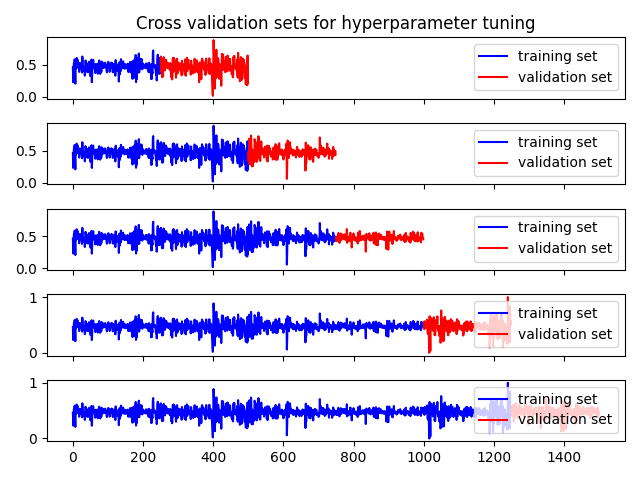

Training multivariate linear regression:

Linear regression coefficients: 
 [-0.01902699 -0.02047458 -0.0519263   0.02986012 -0.01662265 -0.03347946
 -0.05442059  0.01474971 -0.03866493 -0.02003914]
MAPE: 0.40488261510476775
RMSE:  0.18091140702770053
MAE:  0.10953849318984271

Training support vector machine:
best_score:  -0.08941377063610415
best_model:  SVR(C=0.001, max_iter=5000, tol=1e-05)
best_params:  {'C': 0.001, 'kernel': 'rbf'}
MAPE: 0.40266019754413607
RMSE:  0.1835402438172414
MAE:  0.10961175902080379

Training MLP neural network: 
Model params: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 2000, 'momentum': 0.9, 'n_iter_no_change': 100, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': False, 'solver': 'adam', 'tol': 0.0001, 'valida

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 1602960729.1801465
RMSE:  0.011173712177132327
MAE:  0.0071616442749020005
Movement prediction accuracy: 50.7 %
Confusion matrix:
[[335 470]
 [405 565]]
Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 51.61 %
Co

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 1598059905.7981482
RMSE:  0.011376349048096115
MAE:  0.006966210539083311
Movement prediction accuracy: 54.7 %
Confusion matrix:
[[  1 804]
 [  0 970]]
Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 50.93 %
Con

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 400015158.3663353
RMSE:  0.012381264996636627
MAE:  0.007825716185755028
Movement prediction accuracy: 47.72 %
Confusion matrix:
[[318 487]
 [441 529]]
Taking 71 walks during walk forward validation
walk 0
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0054
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0113
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0072
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0025
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
7/7 [==============================] - 0s 16ms/step - loss: 0.0129
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 5230478891.72969
RMSE:  0.01168994528936197
MAE:  0.007309568605490793
Movement prediction accuracy: 51.55 %
Confusion matrix:
[[384 421]
 [439 531]]


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-23,19.640715,19.875000,19.457500,19.863571,17.590788,403239200
1,2014-01-24,19.785713,19.843571,19.455357,19.502501,17.271027,429354800
2,2014-01-27,19.645357,19.814285,19.491072,19.660713,17.411139,554878800
3,2014-01-28,18.170000,18.392857,17.931070,18.089287,16.019512,1065523200
4,2014-01-29,17.998215,18.120358,17.807858,17.883928,15.837652,502810000
...,...,...,...,...,...,...,...
1995,2021-12-23,175.850006,176.850006,175.270004,176.279999,176.055695,68356600
1996,2021-12-27,177.089996,180.419998,177.070007,180.330002,180.100540,74919600
1997,2021-12-28,180.160004,181.330002,178.529999,179.289993,179.061859,79144300
1998,2021-12-29,179.330002,180.630005,178.139999,179.380005,179.151749,62348900


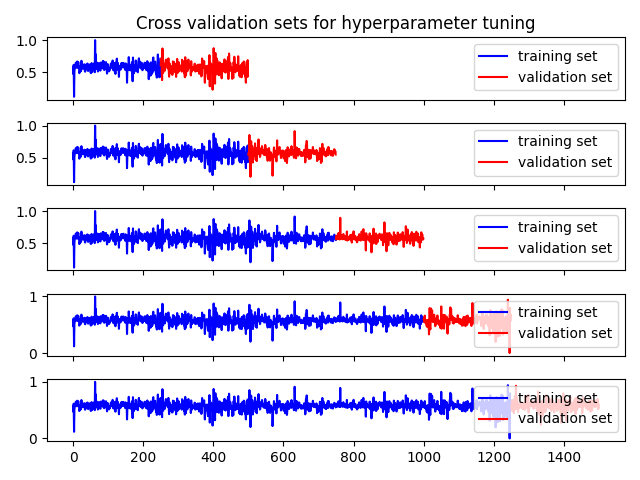

Training multivariate linear regression:

Linear regression coefficients: 
 [-0.01161037  0.03544882 -0.04062341  0.0826644   0.00193926  0.01099798
  0.006965   -0.01653298 -0.03895954  0.01555253]
MAPE: 0.3869351072652647
RMSE:  0.1272425274836353
MAE:  0.0887080603756503

Training support vector machine:
best_score:  -0.08360779781866509
best_model:  SVR(C=0.001, kernel='linear', max_iter=5000, tol=1e-05)
best_params:  {'C': 0.001, 'kernel': 'linear'}
MAPE: 0.4004163910125542
RMSE:  0.1290687387553071
MAE:  0.08914862899417407

Training MLP neural network: 
Model params: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 2000, 'momentum': 0.9, 'n_iter_no_change': 100, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': False, 'solver': 'adam', 'tol':

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 32110668902.296383
RMSE:  0.018500894872991353
MAE:  0.01292736016614502
Movement prediction accuracy: 49.8 %
Confusion matrix:
[[289 545]
 [346 595]]
Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 45.75 %
Conf

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 14444290941.538103
RMSE:  0.018355609532765594
MAE:  0.012629660076534531
Movement prediction accuracy: 49.58 %
Confusion matrix:
[[345 489]
 [406 535]]
Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 46.76 %
Co

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 31064012397.809296
RMSE:  0.01983788203954529
MAE:  0.013938498870846222
Movement prediction accuracy: 49.8 %
Confusion matrix:
[[320 514]
 [377 564]]
Taking 71 walks during walk forward validation
walk 0
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0047
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0082
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0059
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0043
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0090
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
wa

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 42946235758.22863
RMSE:  0.018887888672657623
MAE:  0.013344329238125886
Movement prediction accuracy: 51.44 %
Confusion matrix:
[[443 391]
 [471 470]]


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-04-29,1.385291,1.387900,1.380741,1.385291,1.385291,0
1,2014-04-30,1.381387,1.387700,1.378660,1.381368,1.381368,0
2,2014-05-01,1.386866,1.389101,1.386399,1.386924,1.386924,0
3,2014-05-02,1.387097,1.387099,1.381349,1.387097,1.387097,0
4,2014-05-05,1.387270,1.388800,1.386597,1.387270,1.387270,0
...,...,...,...,...,...,...,...
1995,2021-12-24,1.132464,1.134430,1.130838,1.132734,1.132734,0
1996,2021-12-27,1.132387,1.133500,1.130416,1.132426,1.132426,0
1997,2021-12-28,1.132978,1.133600,1.129038,1.133003,1.133003,0
1998,2021-12-29,1.131337,1.137001,1.127536,1.131478,1.131478,0


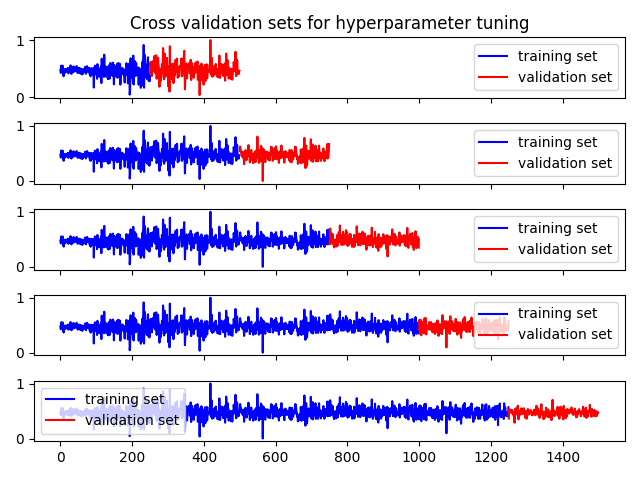

Training multivariate linear regression:

Linear regression coefficients: 
 [-0.04139649 -0.00825616  0.00437094 -0.00689199 -0.06288214  0.02799059
 -0.01301848  0.00101559 -0.0070444  -0.05203343]
MAPE: 0.15001187179050238
RMSE:  0.07869582205589654
MAE:  0.05928095515317116

Training support vector machine:
best_score:  -0.08897076007103717
best_model:  SVR(C=0.001, kernel='sigmoid', max_iter=5000, tol=1e-05)
best_params:  {'C': 0.001, 'kernel': 'sigmoid'}
MAPE: 0.1492991000695617
RMSE:  0.07846000859538964
MAE:  0.05908678861211021

Training MLP neural network: 
Model params: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 2000, 'momentum': 0.9, 'n_iter_no_change': 100, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': False, 'solver': 'adam', 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 18209194307.8015
RMSE:  0.0050595067444147305
MAE:  0.003700650650687987
Movement prediction accuracy: 51.61 %
Confusion matrix:
[[476 419]
 [440 440]]
Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 47.1 %
Conf

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 7538597266.442362
RMSE:  0.004928045868077872
MAE:  0.0036243278554022322
Movement prediction accuracy: 50.08 %
Confusion matrix:
[[642 253]
 [633 247]]
Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 50.25 %
Co

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 33358883566.100792
RMSE:  0.005774233381218537
MAE:  0.004235007915156455
Movement prediction accuracy: 49.3 %
Confusion matrix:
[[390 505]
 [395 485]]
Taking 71 walks during walk forward validation
walk 0
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0096
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0174
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0099
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0072
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0081
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
w

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAPE: 25327528517.200016
RMSE:  0.005072922099582921
MAE:  0.003744695754393142
Movement prediction accuracy: 48.96 %
Confusion matrix:
[[504 391]
 [515 365]]


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-22,95.199997,96.889999,95.120003,96.730003,96.730003,252349
1,2014-01-23,96.690002,97.839996,96.410004,97.320000,97.320000,274078
2,2014-01-24,97.370003,97.800003,96.250000,96.639999,96.639999,239673
3,2014-01-27,96.900002,97.180000,95.209999,95.720001,95.720001,235110
4,2014-01-28,95.660004,97.660004,95.629997,97.410004,97.410004,206490
...,...,...,...,...,...,...,...
1995,2021-12-23,73.029999,73.949997,72.269997,73.790001,73.790001,270223
1996,2021-12-27,73.379997,76.089996,72.570000,75.570000,75.570000,268490
1997,2021-12-28,75.970001,76.919998,75.529999,75.980003,75.980003,249728
1998,2021-12-29,76.040001,77.370003,75.360001,76.559998,76.559998,283557


ValueError: Input contains infinity or a value too large for dtype('float64').

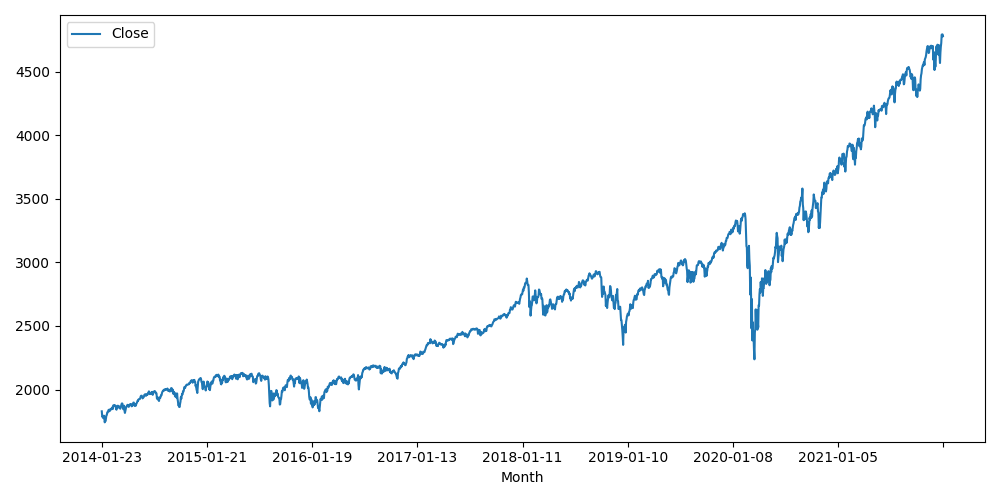

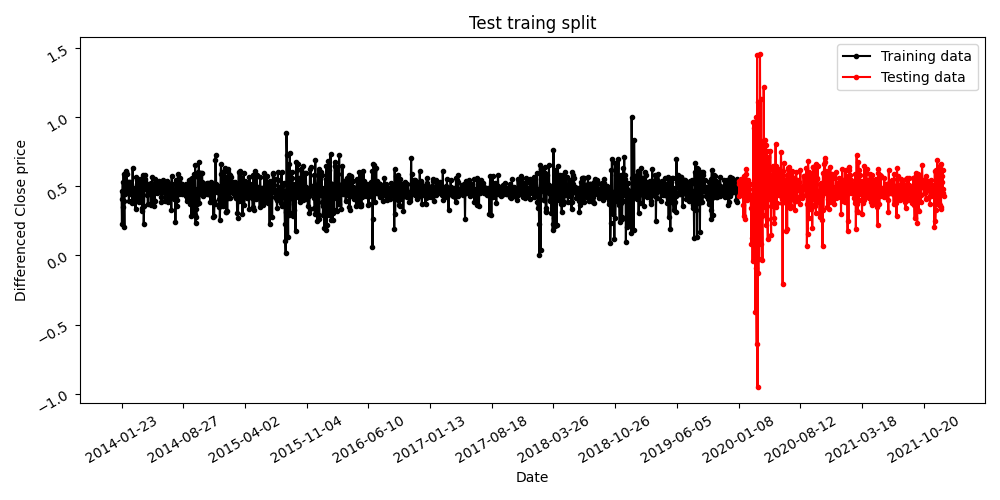

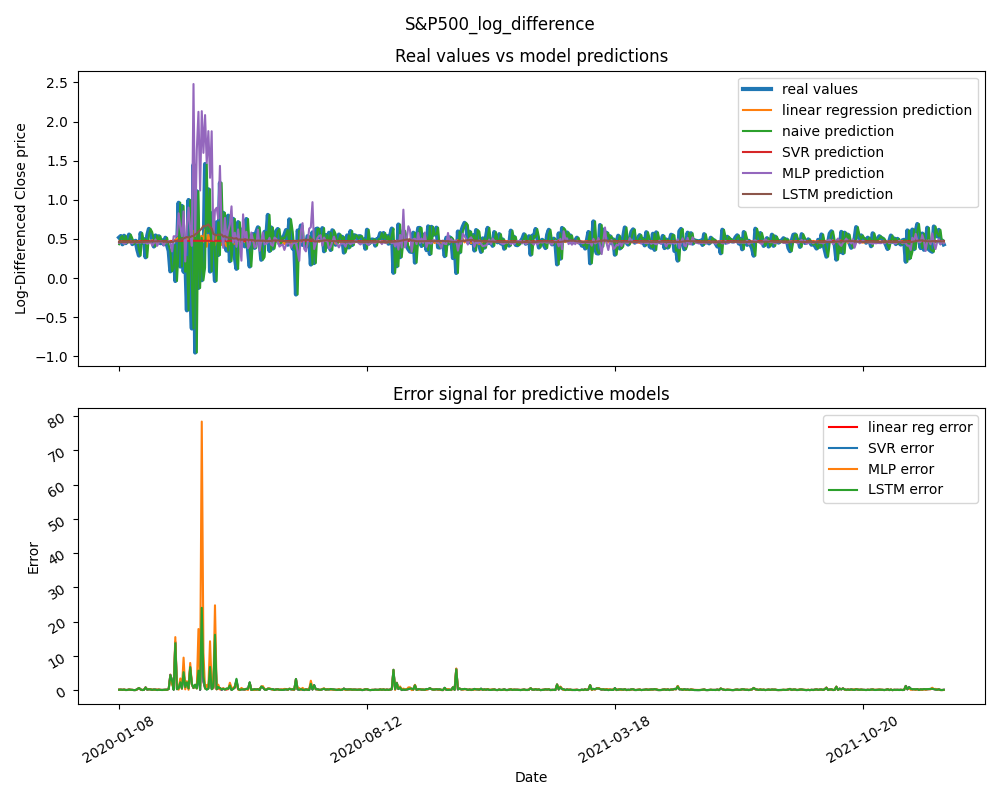

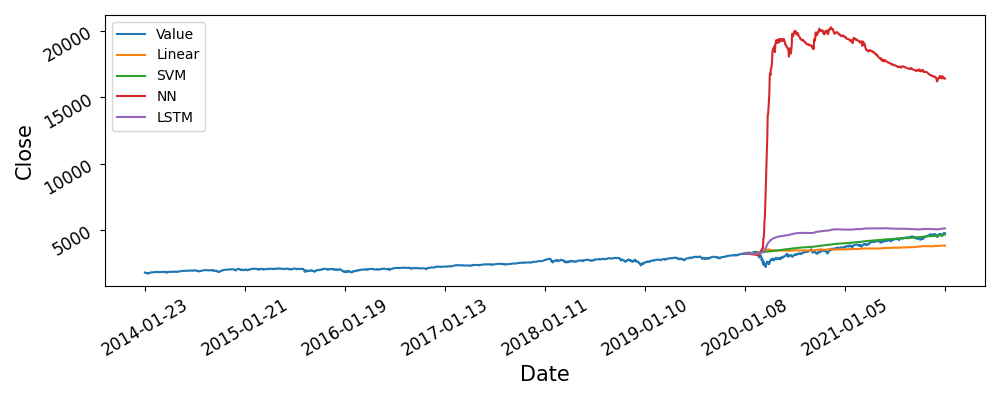

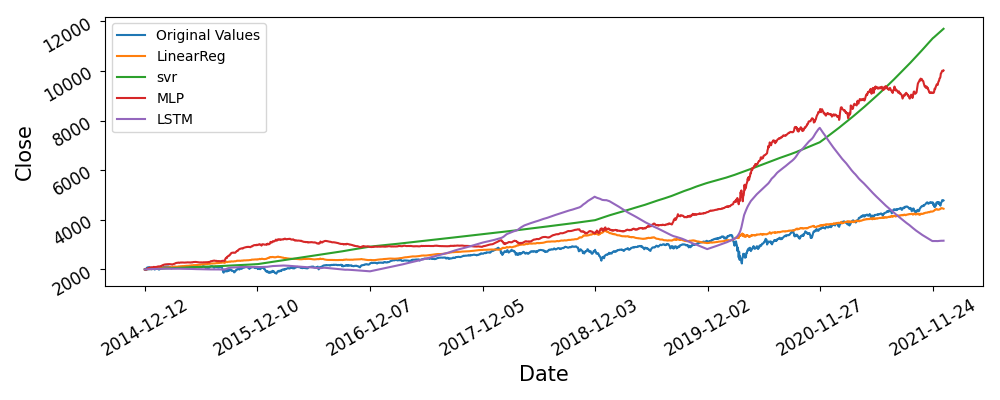

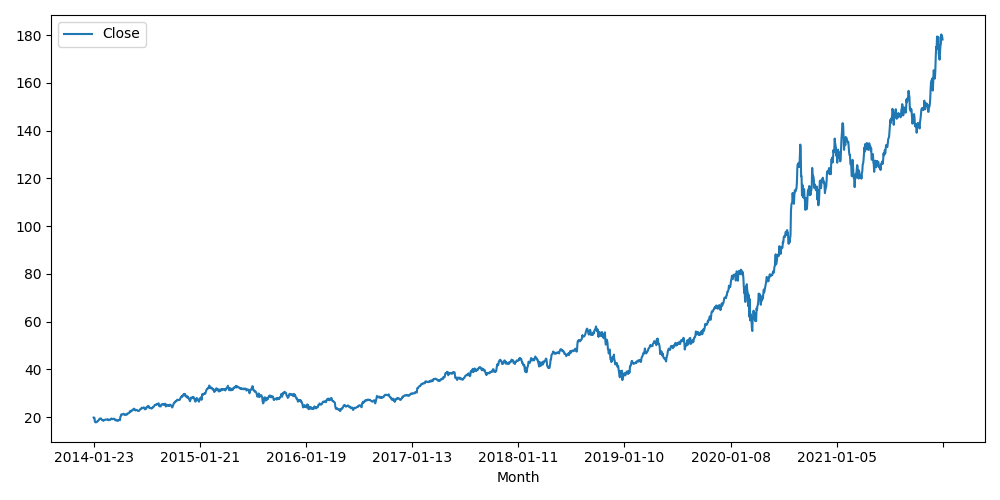

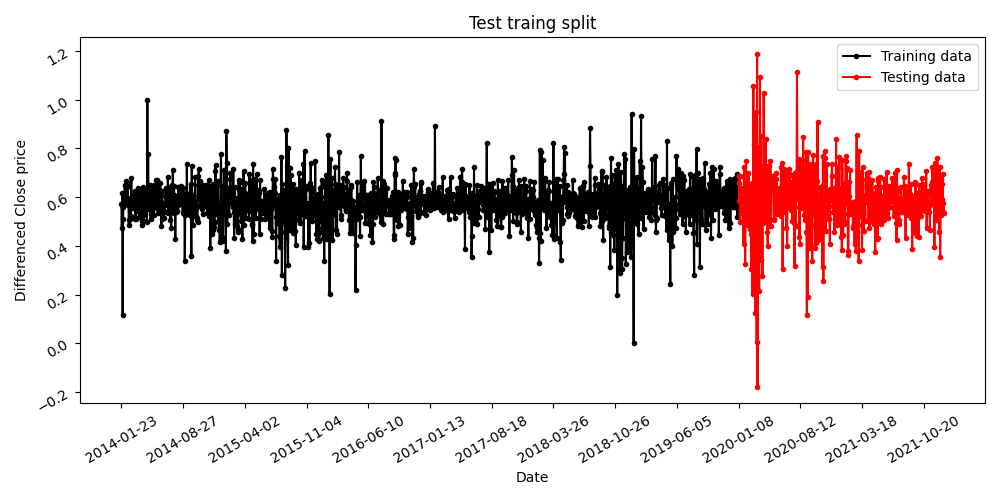

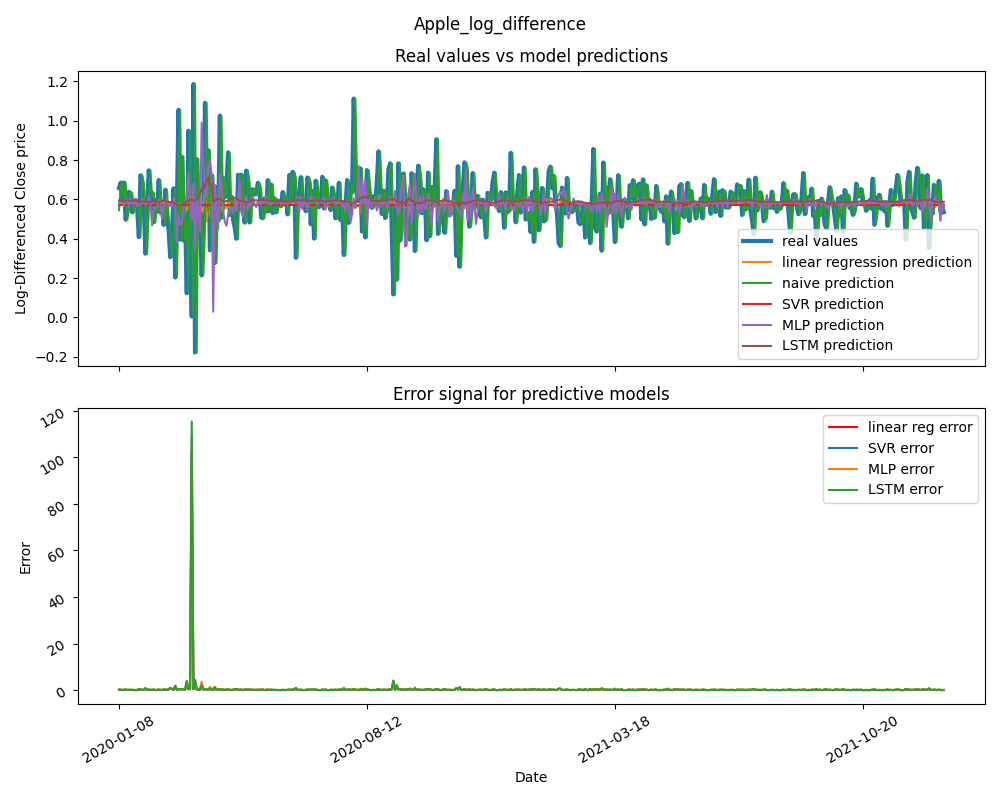

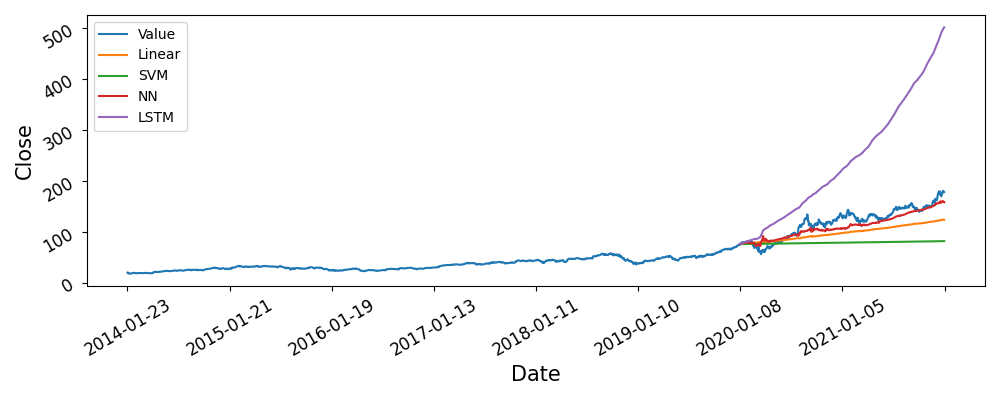

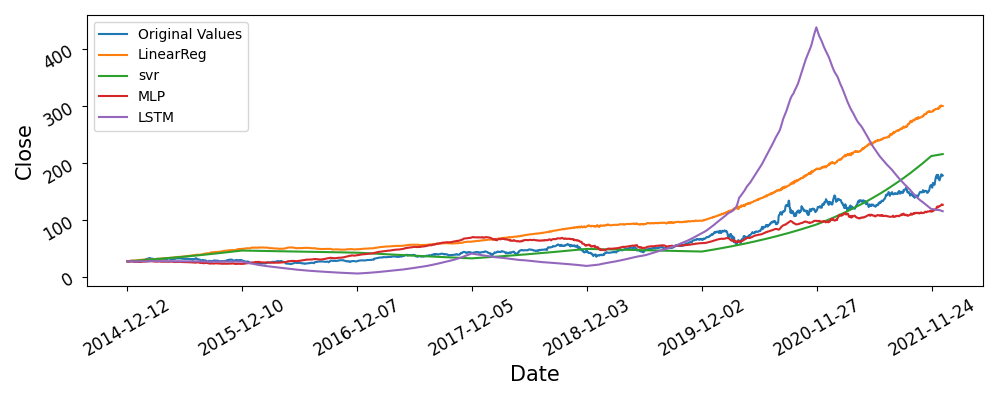

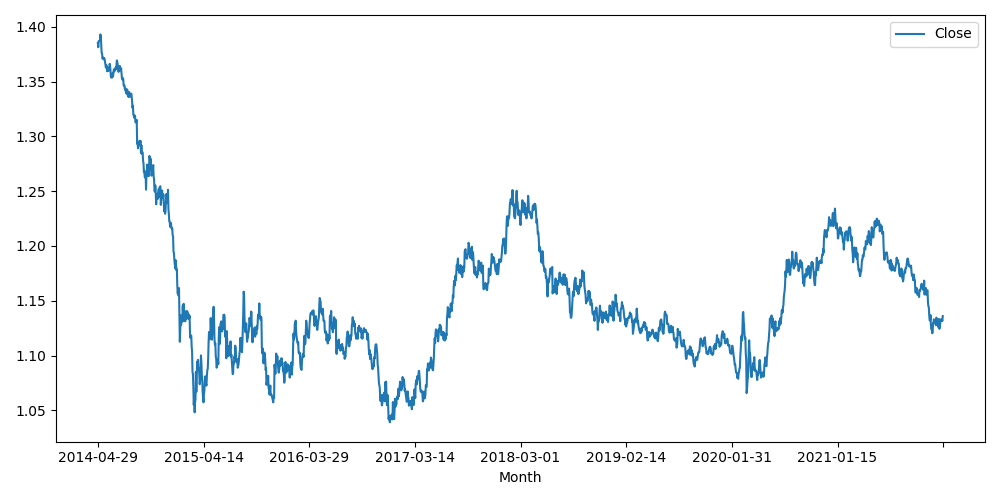

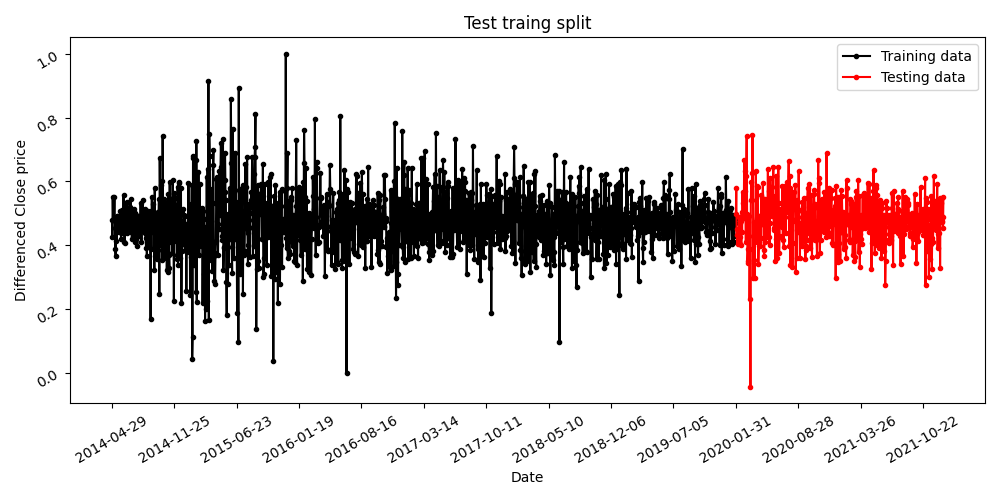

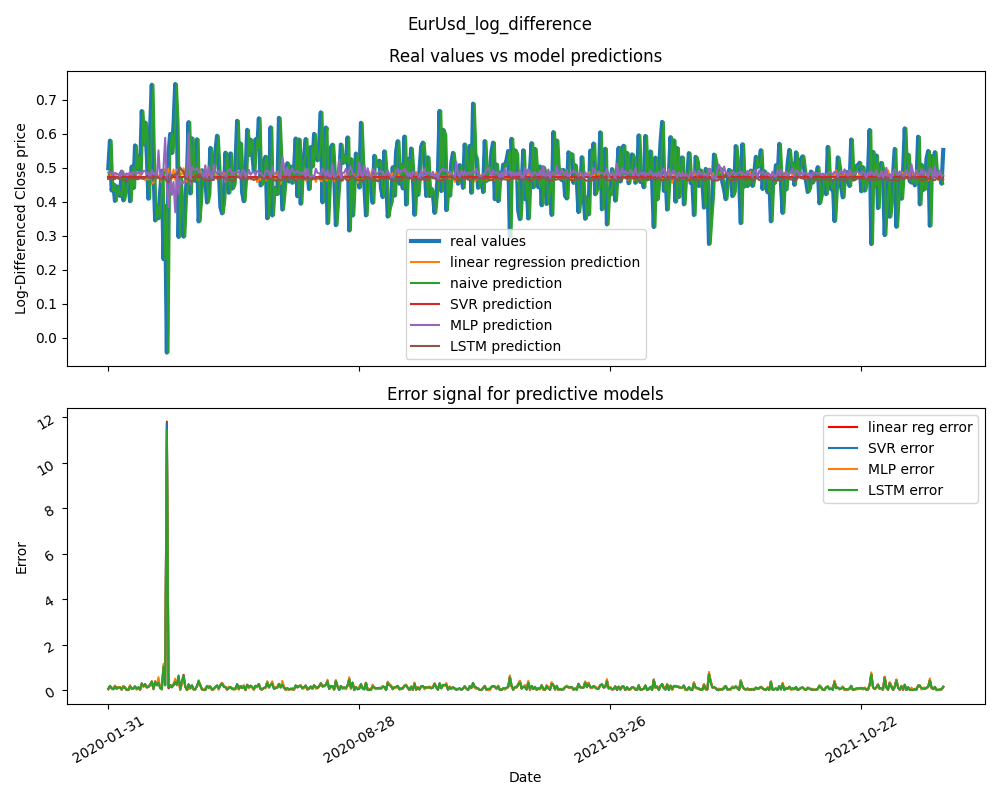

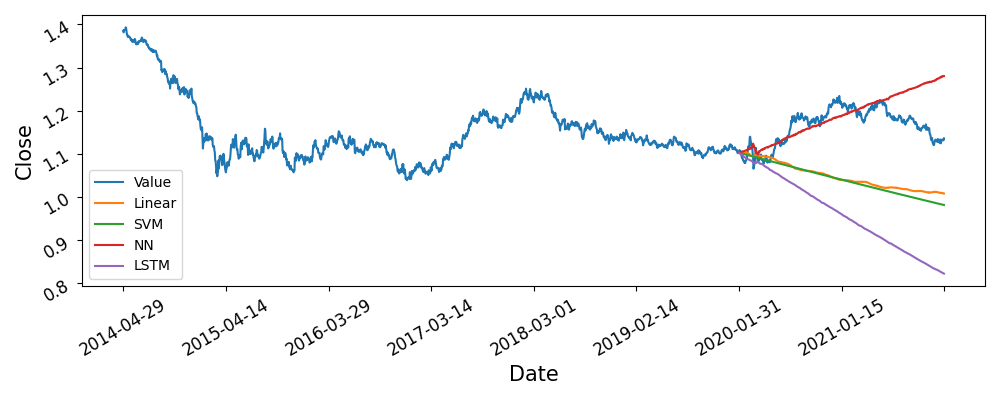

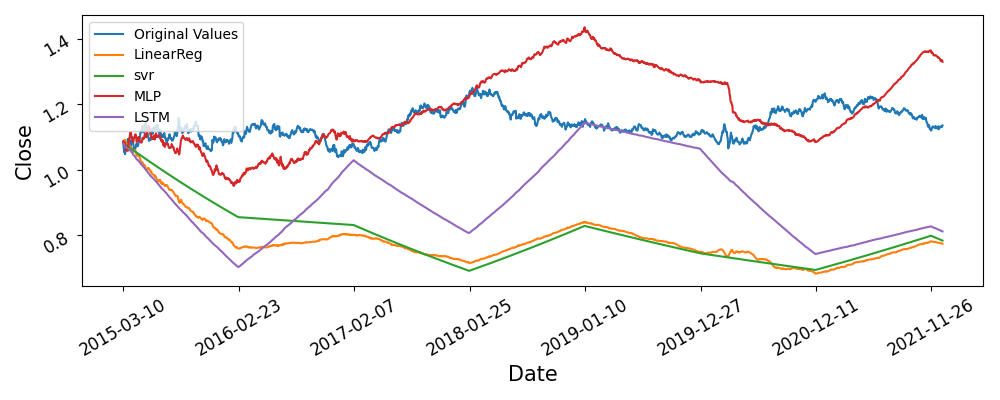

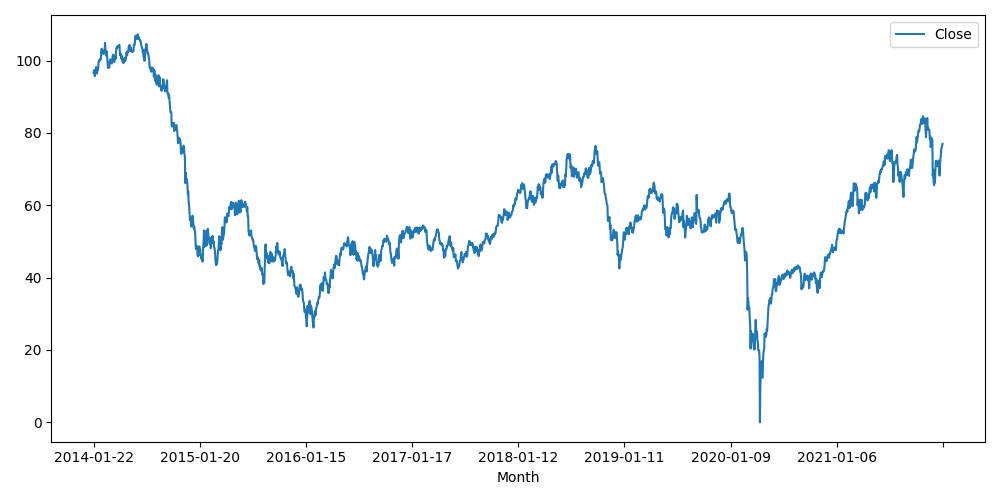

In [42]:
financial_assets = ['S&P500','Apple','EurUsd']#,'CrudeOil'] # ['AirPassengers']#
feat_engineering = 'log_difference'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################
    if financial_asset != 'AirPassengers':
        df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
        df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    else:
        df = pd.read_csv(f'./test_data/{financial_asset}.csv')
        df['Date'] = df['Month'] # for the airplane dataset

    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    ###################################################################################################
    # feature engineer data
    ###################################################################################################
    df['log'] = df[f'{column_to_predict}'].apply(lambda x: np.log(x))
    df['log_diff'] = df['log'].diff(periods=1)
    df['log_diff'].iloc[0] = 0

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(df['log_diff'][0:-split].to_numpy().reshape(-1,1)).flatten()
    scaled_test_data = scaler.transform(df['log_diff'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Differenced Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=False,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=False,n_batch=128)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Log-Differenced Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # invert feature engineering (if possible)
    ###################################################################################################

    # invert scaling
    inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
    inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
    inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
    inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

    # invert differencing for different models
    inverted_lin = invert_first_difference_with_log_2(df[f'log'].iloc[-split],inverted_predictions_linear,df[f'{column_to_predict}'].iloc[-split:], df['Date'].iloc[-split:])
    inverted_svm = invert_first_difference_with_log_2(df[f'log'].iloc[-split],inverted_predictions_svm,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])
    inverted_nn = invert_first_difference_with_log_2(df[f'log'].iloc[-split],inverted_predictions_nn,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])
    inverted_lstm = invert_first_difference_with_log_2(df[f'log'].iloc[-split],inverted_predictions_lstm,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])

    # collect inverted results

    df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
    df_inverted_results['Date'] = df['Date']
    df_inverted_results['Value'] = df[f'{column_to_predict}']
    df_inverted_results['Linear'].iloc[-split:] = inverted_lin['invert_pred_value'].astype(float)
    df_inverted_results['SVM'].iloc[-split:] = inverted_svm['invert_pred_value'].astype(float)
    df_inverted_results['NN'].iloc[-split:] =  inverted_nn['invert_pred_value'].astype(float)
    df_inverted_results['LSTM'].iloc[-split:] = inverted_lstm['invert_pred_value'].astype(float)

    # plot invert results
    ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(rotation=30, labelsize=12)    
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

    # store results
    inverted_conclusion(dates=df['Date'].iloc[-split:],
                        original_values=df[f'{column_to_predict}'].iloc[-split:], 
                        linear_preds=inverted_lin['invert_pred_value'], 
                        svm_pred=inverted_svm['invert_pred_value'], 
                        nn_preds=inverted_nn['invert_pred_value'], 
                        lstm_preds=inverted_lstm['invert_pred_value'],
                        financial_asset=financial_asset,
                        feat_engineer=feat_engineering)


    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model}

    # store evaulation results for different models
    model_results = []
    inverted_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane otherwise 225
        test_len = 25   # 12 for Airplane otherwise 25
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10)
        # wrangle results
        
        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
        ax[0].set_ylabel('Close')

        ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # invert results for different models

        # invert scaling
        inverted_predictions, inverted_testing_data = invert_scaling(scaler,scaled_input_data[train_len:],df_walk_forward['prediction'].to_numpy())
        
        # invert differencing for different models
        inverted_preds = invert_first_difference_with_log_2(
                                first_value=df[f'log'].iloc[train_len],
                                predictions=inverted_predictions,
                                original=df[f'{column_to_predict}'].iloc[train_len:],
                                dates=df['Date'].iloc[train_len:]               
                                        )

        invert_mse = np.sqrt(mean_squared_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_preds['invert_pred_value']))
        invert_mae = mean_absolute_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_preds['invert_pred_value'])
        invert_mape = mean_absolute_percentage_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_preds['invert_pred_value'])
        df_hit_rate, invert_accuracy = hit_rate(dates=df['Date'].iloc[train_len:],
                                        original_values=df[f'{column_to_predict}'].iloc[train_len:],
                                        predictions=inverted_preds['invert_pred_value'])

        inverted_results.append({'model':model_name,'mse':invert_mse,'mae':invert_mae,'mape':invert_mape,'accuracy':invert_accuracy})


        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = inverted_preds['value'].to_numpy()
        model_pred_results[model_name] = inverted_preds['invert_pred_value'].to_numpy()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')
    
    df_conclusion_wf_inverted = pd.DataFrame.from_records(inverted_results)
    df_conclusion_wf_inverted.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_inverted_wf.csv')
    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    latex_table = tabulate(df_conclusion_wf_inverted, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_inverted_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results_inverted.png')



In [38]:
# plt.figure()
# dfff = pd.DataFrame(blah.X_test)
dfff.to_csv('./results/some_ugly_stuff.csv')

In [33]:
df.to_csv('./results/some_ugly_stuff.csv')

In [37]:
dfff = pd.DataFrame(blah.input_data)
dfff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990 entries, 0 to 1989
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1988 non-null   float64
 1   1       1988 non-null   float64
 2   2       1988 non-null   float64
 3   3       1988 non-null   float64
 4   4       1988 non-null   float64
 5   5       1988 non-null   float64
 6   6       1988 non-null   float64
 7   7       1988 non-null   float64
 8   8       1988 non-null   float64
 9   9       1988 non-null   float64
dtypes: float64(10)
memory usage: 155.6 KB
